In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import DataPreprocessor
from mood_RNN_regression import RNNRegressor, MoodDataset, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, pred_df = data_loader.load_and_preprocess_data("1d", 0.5, 1, do_bucketing=False)

Removed 25 outliers from 1002 observations. Percentage: 2.50%


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)

In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, device), n_trials=100)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-20 12:56:24,933] A new study created in memory with name: no-name-f5cbc7bb-56d7-4b1e-85b6-89b0f6e09f1d
[I 2025-04-20 12:56:26,111] Trial 0 finished with value: 20.172782023150223 and parameters: {'hidden_dim': 69, 'id_embed_dim': 5, 'lr': 0.00031560681077071815, 'batch_size': 64}. Best is trial 0 with value: 20.172782023150223.
[I 2025-04-20 12:56:26,380] Trial 1 finished with value: 0.9134806672433265 and parameters: {'hidden_dim': 124, 'id_embed_dim': 16, 'lr': 0.0020110368786670774, 'batch_size': 128}. Best is trial 1 with value: 0.9134806672433265.
[I 2025-04-20 12:56:26,841] Trial 2 finished with value: 1.4201000364203202 and parameters: {'hidden_dim': 32, 'id_embed_dim': 14, 'lr': 0.005536160919286826, 'batch_size': 32}. Best is trial 1 with value: 0.9134806672433265.
[I 2025-04-20 12:56:27,141] Trial 3 finished with value: 1.1589000260919557 and parameters: {'hidden_dim': 52, 'id_embed_dim': 10, 'lr': 0.0014170048991923067, 'batch_size': 64}. Best is trial 1 with valu

Best hyperparams: {'hidden_dim': 87, 'id_embed_dim': 15, 'lr': 0.004631158616231737, 'batch_size': 64}


In [6]:
# Final model
model = RNNRegressor(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [ ]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=25)

Epoch 1: train loss = 41.8795, val loss = 28.8539
Epoch 2: train loss = 17.0950, val loss = 5.2696
Epoch 3: train loss = 3.2577, val loss = 1.4763
Epoch 4: train loss = 1.0786, val loss = 0.8268
Epoch 5: train loss = 0.5550, val loss = 0.5879
Epoch 6: train loss = 0.4345, val loss = 0.5815
Epoch 7: train loss = 0.3817, val loss = 0.5693
Epoch 8: train loss = 0.3508, val loss = 0.5546
Epoch 9: train loss = 0.3342, val loss = 0.5464
Epoch 10: train loss = 0.3175, val loss = 0.5467
Epoch 11: train loss = 0.3069, val loss = 0.5536
Epoch 12: train loss = 0.2943, val loss = 0.5352
Epoch 13: train loss = 0.2836, val loss = 0.5343
Epoch 14: train loss = 0.2723, val loss = 0.5350
Epoch 15: train loss = 0.2658, val loss = 0.5307
Epoch 16: train loss = 0.2544, val loss = 0.5455
Epoch 17: train loss = 0.2457, val loss = 0.5301
Epoch 18: train loss = 0.2377, val loss = 0.5824
Epoch 19: train loss = 0.2265, val loss = 0.5413
Epoch 20: train loss = 0.2158, val loss = 0.5906
Epoch 21: train loss = 0.2

MAE: 0.7134, MSE: 0.8479, MAPE: 10.2816%, MSPE: 12.1989%, R_squared: -0.5203


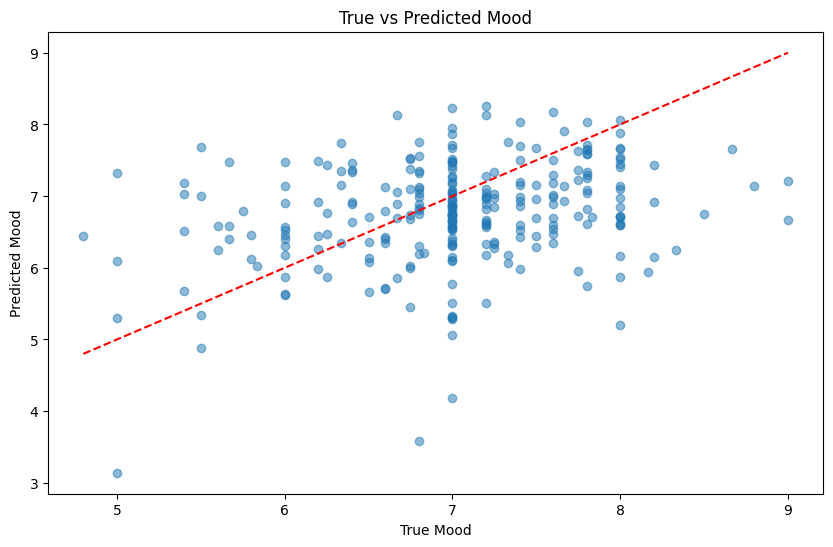

In [8]:
plot_mood_predictions(model, val_loader, device)

In [9]:
# Run predictions on test_df
test_predictions = predict(model, pred_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = pred_df.copy()
test_df_with_preds['predicted_mood'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood']])

         id  predicted_mood
0   AS14.01        6.324702
1   AS14.02        6.071673
2   AS14.03        7.669604
3   AS14.05        5.472640
4   AS14.06        6.571143
5   AS14.07        4.256630
6   AS14.08        7.082426
7   AS14.09        5.807089
8   AS14.12        6.924887
9   AS14.13        6.604551
10  AS14.14        7.250922
11  AS14.15        7.056253
12  AS14.16        6.082699
13  AS14.17        7.006279
14  AS14.19        6.148863
15  AS14.20        6.708916
16  AS14.23        8.915161
17  AS14.24        6.148750
18  AS14.25        6.537370
19  AS14.26        6.951847
20  AS14.27        6.603352
21  AS14.28        6.971186
22  AS14.29        6.450865
23  AS14.30        6.283517
24  AS14.31        7.235413
25  AS14.32        6.569078
26  AS14.33        7.216008
